# NY Housing Price - regression
## Part 4. Model Evaluation & Project Delivery
<br>

<a id = 'toc'></a>
**Table of Contents**
1. [Premodeling function](#pre)
2. [Model evaluation](#eval)
    1. [Load test set](#eval)
    2. [Load models](#model)
    3. [Evaluate models on test_X](#eval1)
3. [Construct model class](#class)
4. [Project delivery](#deliver)

In [60]:
# import libraries
import pandas as pd
import numpy as np

import pickle as pickle

from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
# Load data
train_df = pd.read_csv('../data/analytical_base_table.csv')
print (train_df.shape)

# Create X, y
train_y = train_df['tx_price']
train_X = train_df.drop(['tx_price'], axis = 1)
print (train_y.shape, train_X.shape)

(1505, 48)
(1505,) (1505, 47)


In [4]:
# load raw data 
raw_data = pd.read_csv('../data/train.csv')

In [5]:
raw_data.shape

(1506, 26)

In [6]:
raw_data.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,...,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
0,257840,4,2,3796,1978,20473,Single-Family,Metal,Composition Shingle,1.0,...,0,0,49.0,91.0,83.0,593.0,181.0,8.0,1.0,1997
1,540000,4,3,2500,1971,10500,Single-Family,Brick,Composition Shingle,1.0,...,11,9,46.0,94.0,54.0,487.0,148.0,8.0,3.0,2013
2,300000,4,3,3480,1940,10890,Single-Family,Brick,Asphalt,1.0,...,25,35,45.0,81.0,88.0,1015.0,337.0,4.0,3.0,1993
3,650000,5,4,5809,2002,30056,Single-Family,NaN,Asphalt,1.0,...,5,8,37.0,64.0,55.0,727.0,187.0,7.0,3.0,2004
4,576145,4,3,3504,2004,4199,Single-Family,Siding (Alum/Vinyl),Composition Shingle,1.0,...,12,5,34.0,91.0,59.0,528.0,161.0,7.0,2.0,2005


In [7]:
print (raw_data.shape)
raw_data = raw_data.drop(['tx_price'], axis =1)
print (raw_data.shape)

(1506, 26)
(1506, 25)


<a id = 'pre'></a>
## 1. Premodeling function

1. [clean_data](#clean) 
2. [engineer_feature](#eng)

<a id = 'clean'></a>
### 1.1 clean_data

In [10]:
# data cleaning function
def clean_data(df):
    
    roof_replace_dict = {'asphalt': 'Asphalt', 
                         'composition': 'Composition',
                         'shake-shingle': 'Shake Shingle'}
    df.loc[:, 'roof'] = df['roof'].replace(roof_replace_dict)    
    df.loc[:, 'basement'] = df.basement.fillna(0)
    
    df = df[df.lot_size < 500000]
    
    cat_cols=['property_type', 'exterior_walls', 'roof']    
    for c in cat_cols:
        df.loc[:,c] = df[c].fillna('Missing')
        
    return df

In [11]:
cleaned_data = clean_data(raw_data)

print ( cleaned_data.shape)

(1505, 25)


<a id = 'eng'></a>
### 1.2 engineer_features

In [28]:
def engineer_features(df):
    
    df.loc[:,'2ba2be'] = ((df.baths == 2) & (df.beds == 2)).astype(int)
    df.loc[:,'recession_ind'] = df.tx_year.between(2008, 2014).astype(int)
    df.loc[:,'property_age'] = df.tx_year - df.year_built
    df.loc[:,'age_neg_ind'] = (df.property_age < 0)
    df.loc[df.property_age < 0, 'property_age'] = 0
    df = df.drop(['tx_year', 'year_built'], axis = 1)
    df.loc[:,'school_score'] = df.num_schools * df.median_school
    df.loc[:,'ba2be'] = df.baths*1.0/df.beds
    
    df.loc[:,'roof'] = df['roof'].replace(['asphalt,shake-shingle', 'Built-up','Metal','Slate','Asbestos'], 'Other')
    df.loc[:,'roof'] = df['roof'].replace('Composition', 'Composition Shingle')
    
    df.loc[:,'exterior_walls'] = df['exterior_walls'].replace(['Wood Siding','Wood Shingle'], 'Wood')
    df.loc[:,'exterior_walls'] = df['exterior_walls'].replace(['Concrete Block','Block'], 'Concrete')
    df.loc[:,'exterior_walls'] = df['exterior_walls'].replace('Rock, Stone', 'Masonry')
    df.loc[:,'exterior_walls'] = df['exterior_walls'].replace('Asbestos shingle', 'Other')
    
    df = pd.get_dummies
    
    return df

In [29]:
augmented_data = engineer_features(cleaned_data)
print (cleaned_data.shape, augmented_data.shape)

(1505, 29) (1505, 47)


In [30]:
(train_X == augmented_data.reset_index(drop=True)).all().all()

True

[back to top](#toc)

<a id = 'eval'></a>

## 2. Model evaluation

### 2.A. Load test set

In [36]:
test_data = pd.read_csv('../data/test.csv')
print(test_data.shape)

(377, 26)


In [37]:
test_y = test_data.tx_price
test_X = test_data.drop(['tx_price'], axis = 1)
print (test_X.shape, test_y.shape)

(377, 25) (377,)


In [38]:
# Premodeling function
test_X = engineer_features(clean_data(test_X))
print(test_X.shape)

(377, 47)


[back to top](#toc)

<a id = 'load'></a>
### 2.B. Load models

In [19]:
with open('../models/fitted_final_models.pkl', 'rb') as f:
    fitted_final_models = pickle.load(f)

[09:44:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [20]:
with open('../models/fitted_final_models_mae.pkl', 'rb') as f:
    fitted_final_models_mae = pickle.load(f)

In [40]:
# verify model 
for name, model in fitted_final_models.items():
    score_loaded_model = int(mean_absolute_error(train_y, model.predict(train_X)))
    score_loaded_score = int(fitted_final_models_mae[name])
    print ('MAE on train_X from loaded {} model is {}, is should be {}'.format(name, score_loaded_model, score_loaded_score))

MAE on train_X from loaded lasso model is 93067, is should be 93067
MAE on train_X from loaded rf model is 28725, is should be 28725
MAE on train_X from loaded xgb model is 69732, is should be 69732


[back to top](#toc)

<a id = 'eval1'></a>
### 2.C. Evaluate models on test_X

In [41]:
for name, model in fitted_final_models.items():
    score = int(mean_absolute_error(test_y, model.predict(test_X)))
    print ('MAE on test_X for {} is {}'.format(name, score))

MAE on test_X for lasso is 90727
MAE on test_X for rf is 72623
MAE on test_X for xgb is 75025


<div class = 'alert alert-info'>

**CONCLUSION: RandomForestRegressor stil has the best performance. Evaluation result is consistent with cross validation result. Although, it is really close to xgb's performance** 

In [46]:
fi = permutation_importance(fitted_final_models['rf'], test_X, test_y, 'neg_mean_absolute_error', 10, -2)['importances_mean']

In [54]:
features = test_X.columns
fi_dict = dict(zip(features, fi))
fi_df = pd.DataFrame.from_dict(fi_dict, orient = 'index').rename(columns = {0: 'permutation_importance'})

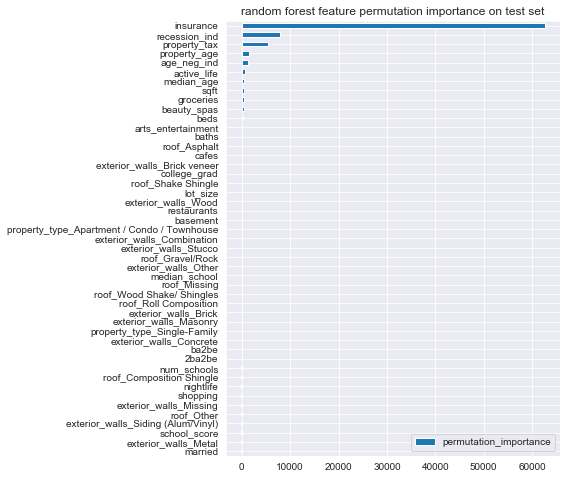

In [64]:
fi_df.sort_values('permutation_importance').plot(kind = 'barh', figsize = (6, 8))
plt.title('random forest feature permutation importance on test set')
plt.show()

**Insurance, recession, property_tax, property age, again, are all importance factors which is consisent with training. Neighborhood features play a lessor role compared with training, which indicates where overfitting likely happened.**

[back to top](#toc)

<a id = 'class'></a>
## 3. Construct model class

In [30]:
with open('../models/fitted_final_models.pkl', 'rb') as f:
    model = pickle.load(f)['rf']

[17:37:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
class HousePriceModel:
    
    def __init__(self, model_location):
        with open(model_location, 'rb') as f:
            self.model = pickle.load(f)['rf']
    
    def predict(self, X, clean=True, augment=True):
        if clean == True:
            X = self.clean_data(X)
        if augment == True:
            X = self.engineer_features(X)
        return X, self.model.predict(X)
    
    
    def clean_data(self, df):
    
        roof_replace_dict = {'asphalt': 'Asphalt', 
                             'composition': 'Composition',
                             'shake-shingle': 'Shake Shingle'}
        df.loc[:, 'roof'] = df['roof'].replace(roof_replace_dict)

        df.loc[:,'basement'] = df.basement.fillna(0)

        df = df.loc[df.lot_size < 500000, :]

        cat_cols=['property_type', 'exterior_walls', 'roof']
        for c in cat_cols:
            df.loc[:,c] = df[c].fillna('Missing')
        
        return df    
    
    
    def engineer_features(self, df):
    
        df.loc[:,'2ba2be'] = ((df.baths == 2) & (df.beds == 2)).astype(int)
        df.loc[:,'recession_ind'] = df.tx_year.between(2008, 2014).astype(int)
        df.loc[:,'property_age'] = df.tx_year - df.year_built
        df.loc[:,'age_neg_ind'] = (df.property_age < 0)
        df.loc[df.property_age < 0,'property_age'] = 0
        df = df.drop(['tx_year', 'year_built'], axis = 1)
        df.loc[:,'school_score'] = df.num_schools * df.median_school
        df.loc[:,'ba2be'] = df.baths*1.0/df.beds

        df.loc[:,'roof'] = df['roof'].replace(['asphalt,shake-shingle', 'Built-up','Metal','Slate','Asbestos'], 'Other')
        df.loc[:,'roof'] = df['roof'].replace('Composition', 'Composition Shingle')

        df.loc[:,'exterior_walls'] = df['exterior_walls'].replace(['Wood Siding','Wood Shingle'], 'Wood')
        df.loc[:,'exterior_walls'] = df['exterior_walls'].replace(['Concrete Block','Block'], 'Concrete')
        df.loc[:,'exterior_walls'] = df['exterior_walls'].replace('Rock, Stone', 'Masonry')
        df.loc[:,'exterior_walls'] = df['exterior_walls'].replace('Asbestos shingle', 'Other')

        df = pd.get_dummies(df)

        return df
            

In [39]:
model = HousePriceModel('../models/fitted_final_models.pkl')

[18:01:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
pred1 = fitted_final_models['rf'].predict(augmented_data)

In [41]:
_, pred2 = model.predict(augmented_data, clean=False, augment=False)
_, pred3 = model.predict(cleaned_data, clean=False)
_, pred4 = model.predict(raw_data)
print (np.array_equal(pred1, pred2), np.array_equal(pred1, pred3), np.array_equal(pred1, pred4))

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

True True True


<a id = 'deliever'></a>

## 4. Project delievery

In [67]:
final_model= fitted_final_models['rf']

In [68]:
mean_absolute_error(train_y, final_model.predict(train_X))

28725.33483942414

In [72]:
with open('../deliverables/final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [73]:
with open('../deliverables/final_model.pkl', 'rb') as f:
    final_model = pickle.load(f)

In [74]:
mean_absolute_error(train_y, final_model.predict(train_X))

28725.33483942414

**This is the end of the end of the project.**